In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Sample for exponential distribution

In [2]:
def sample(mu, N=1):
    if N == 1:
        y = np.random.rand()
    else:
        y = np.random.rand(N)
    x = -np.log(1-y)/mu
    return x

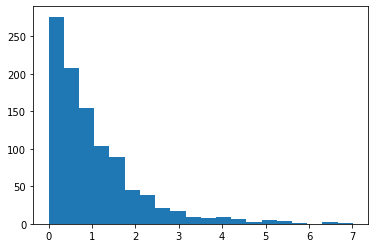

In [3]:
S = sample(1, 1000)
plt.hist(S, 20);

### Event Queue
A priority queue, sorted by event time

In [4]:
class EventQueue:
    def __init__(self):
        self.events = []

    def push(self, time, event):
        self.events.append((time, event))
        self.events.sort(reverse=True)

    def pop(self):
        return self.events.pop()

    def is_empty(self):
        return len(self.events) == 0

pop event with least time

In [5]:
eq = EventQueue()
eq.push(3, "a")
eq.push(2, "b")
eq.push(5, "c")
while not eq.is_empty():
    print(eq.pop())

(2, 'b')
(3, 'a')
(5, 'c')


### Simulation

In [6]:
class Gatekeeper:
    def __init__(self, mu, world):
        self.mu = mu
        self.num = 1
        self.world = world

    def wakeup(self, time, event):
        if event == "arrive":
            self.add_car(time)

            if self.world.sampler:
                dt = self.world.sampler.sample_arrive(self.mu)
            else:
                dt = sample(self.mu)
            self.world.events.push(time+dt, "arrive")
            self.world.events.push(time, "serve")

    def add_car(self, time):
        #print("car #{} arrived at {}".format(self.num, time))
        t, n = self.world.arrival_curve[-1]
        self.world.arrival_curve.append([time, n])
        self.world.arrival_curve.append([time, self.num])
        self.world.arrive_times.append(time)

        self.world.road.append(self.num)
        self.num += 1
            


class Toll:
    def __init__(self, rho, world):
        self.rho = rho
        self.in_service = None
        self.world = world

    def wakeup(self, time, event):
        if event == "serve" and self.in_service is None and self.world.road:
            self.serve_car(time)
            if self.world.sampler:
                dt = self.world.sampler.sample_serve(self.rho)
            else:
                dt = sample(self.rho)
            self.world.events.push(time+dt, "leave")
        elif event == "leave":
            self.release_car(time)
            self.world.events.push(time, "serve")

    def serve_car(self, time):
        self.world.serve_times.append(time)
        car = self.world.road.pop(0)
        self.in_service = car

    def release_car(self, time):
        #print("car #{} leave at {}".format(self.in_service, time))
        t, n = self.world.departure_curve[-1]
        self.world.departure_curve.append([time, n])
        self.world.departure_curve.append([time, self.in_service])
        self.world.leave_times.append(time)

        self.in_service = None        
    
        
class World:
    def __init__(self, mu=0.01, rho=0.02, sampler=None):
        self.sampler = sampler
        self.events = EventQueue()
        self.road = []
        self.gate = Gatekeeper(mu, self)
        self.toll = Toll(rho, self)

        self.arrival_curve = [(0, 0)]
        self.departure_curve = [(0, 0)]

        self.arrive_times = []
        self.serve_times = []
        self.leave_times = []

        self.time = 0
        if self.sampler:
            dt = self.sampler.sample_arrive(mu)
        else:
            dt = sample(mu)
        self.events.push(self.time + dt, "arrive")
        
    def run(self, T=3600):

        while not self.events.is_empty():
            self.time, event = self.events.pop()
            if self.time >= T and event == "arrive":
                break
            self.gate.wakeup(self.time, event)
            self.toll.wakeup(self.time, event)

In [7]:
from matplotlib.ticker import MaxNLocator

def draw(world):
    plt.figure(figsize=(10,7.5), dpi=150)
    t, n = list(zip(*world.arrival_curve))
    plt.plot(t, n, "r", alpha = 0.8, label="arrival")
    t, n = list(zip(*world.departure_curve))
    plt.plot(t, n, "blue", alpha = 0.8, label="departure")
    plt.legend()
    plt.title("Cumulative Arrival-Departure Curves")
    plt.xlabel("time")
    plt.ylabel("# of cars")
    plt.xticks([0, 30, 60], ["8:30", "9:00", "9:30"])
    plt.plot([60, 60], [0, 20], "--g")
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

In [8]:
def statistics(world, T):
    n = len(world.arrive_times)
    wait_times = []
    system_times = []

    for i in range(n):
        arrive_time = world.arrive_times[i]
        if i < len(world.serve_times):
            serve_time = world.serve_times[i]
        else:
            serve_time = T

        if i < len(world.leave_times):
            leave_time = world.leave_times[i]
        else:
            leave_time = T

        wait_times.append(serve_time - arrive_time)
        system_times.append(leave_time - arrive_time)

    return sum(wait_times)/n, sum(system_times)/n, sum(wait_times)/T
        

In [9]:
class Sampler:
    def __init__(self, studentid):
        filename = r"Random_number_table/RandomTable_{}.txt".format(studentid)
        with open(filename, "r") as f:
            lines = f.readlines()

        self.arrive_times = lines[2][10:-1].split(",")
        self.leave_times = lines[4][12:-1].split(",")

    def sample_arrive(self, mu):
        y = float(self.arrive_times.pop(0))
        x = -np.log(1-y)/mu
        return x
        
    def sample_serve(self, mu):
        y = float(self.leave_times.pop(0))
        x = -np.log(1-y)/mu
        return x

(7.31429994224751, 10.83512829710464, 1.706669986524419)

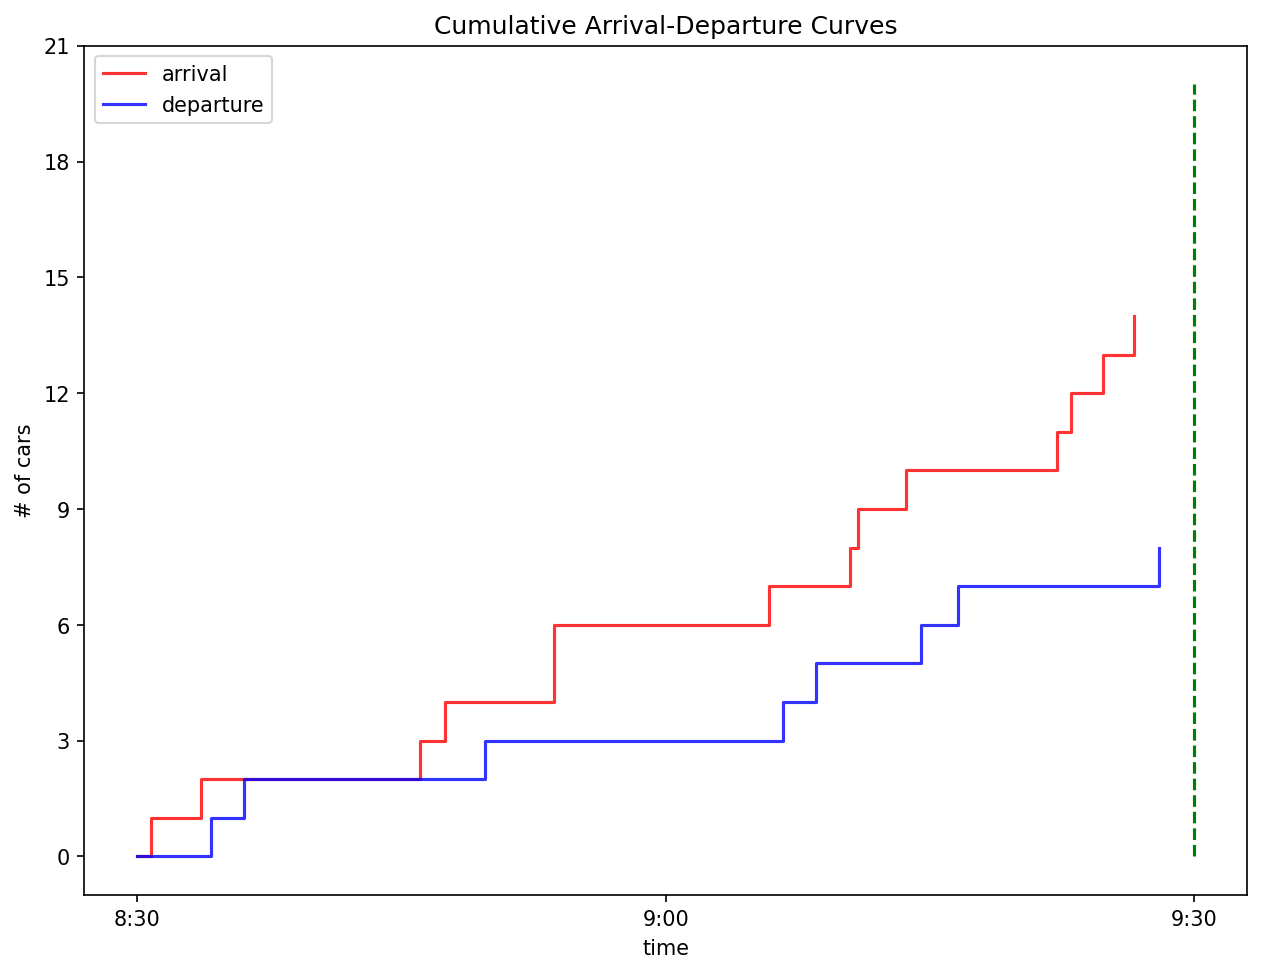

In [16]:
sampler = Sampler(201292223)
mu = 20/60
rho = 1/5
T = 60
world = World(mu, rho, sampler)
world.run(T)
draw(world)
statistics(world, T)

In [17]:
print(world.arrival_curve)

[(0, 0), [0.7569447858434687, 0], [0.7569447858434687, 1], [3.6204806199265276, 1], [3.6204806199265276, 2], [16.025980290153594, 2], [16.025980290153594, 3], [17.48926134265858, 3], [17.48926134265858, 4], [23.633089966519975, 4], [23.633089966519975, 5], [23.64511403071259, 5], [23.64511403071259, 6], [35.86873983549035, 6], [35.86873983549035, 7], [40.46617044938427, 7], [40.46617044938427, 8], [40.9361318795204, 8], [40.9361318795204, 9], [43.62559619325433, 9], [43.62559619325433, 10], [52.219708226697094, 10], [52.219708226697094, 11], [52.988258442874326, 11], [52.988258442874326, 12], [54.81467653925291, 12], [54.81467653925291, 13], [56.613647051670725, 13], [56.613647051670725, 14]]


In [18]:
print(world.departure_curve)

[(0, 0), [4.18283984039731, 0], [4.18283984039731, 1], [6.074522043996868, 1], [6.074522043996868, 2], [19.769279742604613, 2], [19.769279742604613, 3], [36.676253514434485, 3], [36.676253514434485, 4], [38.517100131256825, 4], [38.517100131256825, 5], [44.52032520242313, 5], [44.52032520242313, 6], [46.62068150491076, 6], [46.62068150491076, 7], [58.034593833400095, 7], [58.034593833400095, 8]]
